# Cepstrum-Based Deconvolution for Speech Dereverberation

In [113]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
import scipy.signal as signal
from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import soundfile as sf

In [114]:
fs = 4000 # sampling rate (Hz)

rt60_tgt = 0.8  # reverberation time (s)
room_dim = [10, 7.5, 3.5]  # room dimensions (m)

source_pos = [5, 1, 1] # x, y, z position of the source (m)
mic_locs = np.c_[ [2, 5, 1.2], [9, 5, 3]] # location of the microphone / microphone array (m)

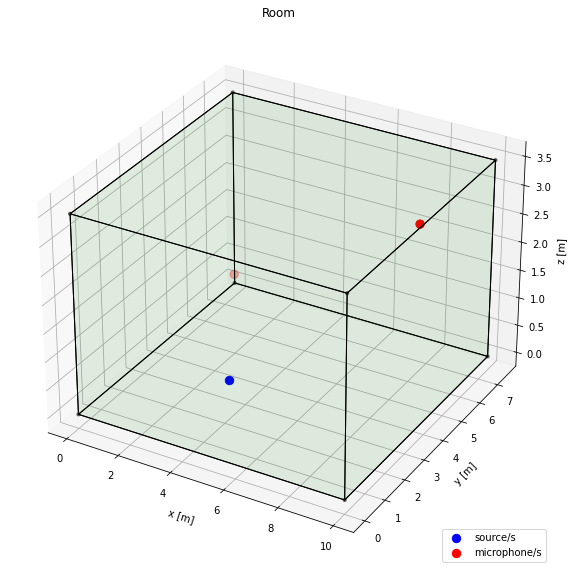

In [115]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70)
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70)

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

In [116]:
# import a mono wavfile as the source signal: the sampling frequency should match that of the room
audio, fs = librosa.load('audio/voiced_a.wav', sr=fs)
audio=audio[:200]

In [117]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

The volume of the room is 262.5 m³


In [118]:
# place the source in the room
room.add_source(source_pos, signal=audio); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [119]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
room.mic_array.to_wav(
    f"audio/generated/voiced_aREV.wav",
    norm=True,
    bitdepth=np.int16,
)

x_rev = room.mic_array.signals[0, :];

global_delay = pra.constants.get("frac_delay_length") // 2

print('Global delay introduced by the simulation:', global_delay)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[0, 0]))

Global delay introduced by the simulation: 40
The desired RT60 was 0.8 s
The measured RT60 is 1.32575 s


Original signal: (200,)
RIR: (1, 10146)
Reverberated signal: (10356,)


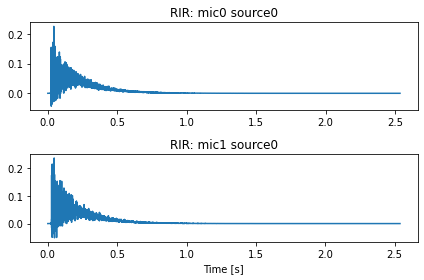

In [120]:
# Plot the RIRs
room.plot_rir()

print('Original signal:', audio.shape)
print('RIR:', np.asarray(room.rir[0]).shape )
print('Reverberated signal:', np.asarray(room.mic_array.signals[0, :]).shape)

In [121]:
# x1:
x1 = room.mic_array.signals[0, :]
ipd.display(ipd.Audio(x1, rate=fs))

In [122]:
# x2:
x2 = room.mic_array.signals[1, :]
ipd.display(ipd.Audio(x2, rate=fs))

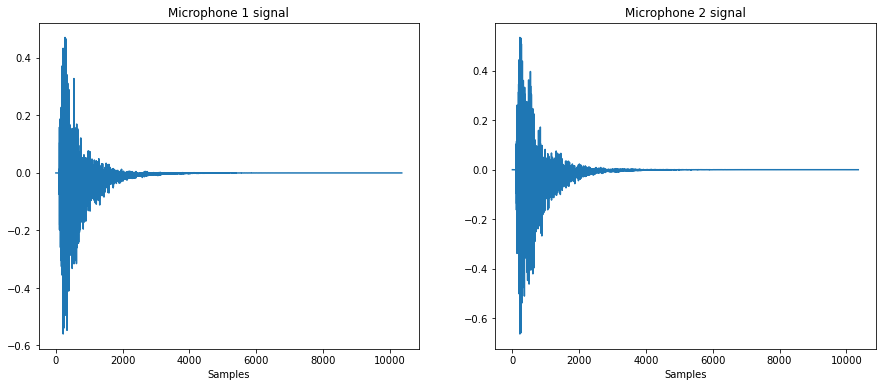

In [123]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(x1)
plt.title("Microphone 1 signal")
plt.xlabel("Samples")
plt.subplot(1,2,2)
plt.plot(x2)
plt.title("Microphone 2 signal")
plt.xlabel("Samples");

### Cepstrum based deconvolution for speech dereverberation

In [124]:
sig_length = len(x1)
N_samples = int(pow(2, np.ceil(np.log(sig_length)/np.log(2))))
K = N_samples

X1 = np.fft.fft(x1, n=K)
X1_hat = np.log(X1)
X1_hat_mag = np.abs(X1_hat)

X1_hat_ph = np.angle(X1_hat)

X1_hat_phu = np.unwrap(X1_hat_ph)

# X1_hat_u = X1_hat_mag*np.exp(1j*X1_hat_phu)

X2 = np.fft.fft(x2, n=K)
X2_hat = np.log(X2)
X2_hat_mag = np.abs(X2_hat)

X2_hat_ph = np.angle(X2_hat)

X2_hat_phu = np.unwrap(X2_hat_ph)

# X2_hat_u = X2_hat_mag*np.exp(1j*X2_hat_phu)

In [125]:
W = np.zeros((N_samples), dtype=np.complex)
m =np.arange(N_samples//2)

for lam in tqdm(range(N_samples)):
    W[lam] = np.sum(np.exp(-1j*(2*np.pi/N_samples)*m*lam)) # fai con fft

100%|██████████████████████████████████████████████████████████████████████████| 16384/16384 [00:09<00:00, 1790.20it/s]


In [126]:
step = np.ones((N_samples,1))
W1 = np.fft.fft(step)

In [127]:
W.shape
# plt.plot(np.abs(W))
# plt.xlim([0,20])

(16384,)

In [128]:
X_diff = (X1_hat-X2_hat)

phi_min = np.imag(np.convolve(X_diff, W))

In [129]:
for l in range(2, len(h1)+len(h2)+1):
    for m in range(l):
        if ... converges
            p2_plus = m
            L_min = l
            break

SyntaxError: invalid syntax (<ipython-input-129-29c03e13bc7e>, line 3)